<a href="https://colab.research.google.com/github/juanazorzolo/TP-CV-ZORZOLO/blob/main/TP_CV_ZORZOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TRABAJO PRÁCTICO FINAL CV 2025 - SISTEMA DE DETECCIÓN Y CLASIFICACIÓN DE RAZAS DE PERROS**

**AUTOR: Juana Zorzolo Rubio (Z-1217/3)**

Objetivo General:

Desarrollar un pipeline completo de visión por computadora para la identificación de razas de perros en imágenes. El proyecto abarca desde la creación de un sistema de búsqueda por similitud hasta la implementación de un sistema de detección y clasificación en imágenes complejas, incluyendo el entrenamiento y la optimización de modelos de Deep Learning.


# Etapa 1: Buscador de Imágenes por Similitud

## Creación de la Base de Datos Vectorial

In [107]:
!gdown "1u49CNdEEr38PcDx57LAXj1scytX-jjXR" --output "kaggle.json"

Downloading...
From: https://drive.google.com/uc?id=1u49CNdEEr38PcDx57LAXj1scytX-jjXR
To: /content/kaggle.json
100% 68.0/68.0 [00:00<00:00, 397kB/s]


In [55]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"juanazorzolo","key":"16e8ca4c7eebb08f98f32ced7754996d"}'}

In [56]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [57]:
!kaggle datasets download -d gpiosenka/70-dog-breedsimage-data-set
!unzip -q 70-dog-breedsimage-data-set.zip -d /content/

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/70-dog-breedsimage-data-set
License(s): CC0-1.0
70-dog-breedsimage-data-set.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/dogs.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [58]:
# PREPARACIÓN DEL ENTORNO

!pip install -q gradio faiss-cpu torchvision
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
import faiss

In [59]:
# Mostrar las carpetas que existen en /content
print("Contenido de /content:")
for nombre in os.listdir("/content"):
    print("-", nombre)

Contenido de /content:
- .config
- kaggle (2).json
- test
- tp_cv-1
- .gradio
- temp.jpg
- dogs.csv
- train
- valid
- kaggle (1).json
- modelo_resnet18_finetuned (1).pth
- varios_perros.webp
- yolov8n.pt
- kaggle.json
- modelo_resnet18_finetuned.pth
- 70-dog-breedsimage-data-set.zip
- sample_data


In [60]:
import os

# Ruta al dataset (puede ser 'train', 'valid' o 'test')
base_path = "/content/train"

# Obtener nombres de carpetas (razas)
razas = sorted(os.listdir(base_path))
print(f"Total de razas: {len(razas)}")
print("Listado de razas:")
for i, raza in enumerate(razas, 1):
    print(f"{i:02d}. {raza}")

Total de razas: 70
Listado de razas:
01. Afghan
02. African Wild Dog
03. Airedale
04. American Hairless
05. American Spaniel
06. Basenji
07. Basset
08. Beagle
09. Bearded Collie
10. Bermaise
11. Bichon Frise
12. Blenheim
13. Bloodhound
14. Bluetick
15. Border Collie
16. Borzoi
17. Boston Terrier
18. Boxer
19. Bull Mastiff
20. Bull Terrier
21. Bulldog
22. Cairn
23. Chihuahua
24. Chinese Crested
25. Chow
26. Clumber
27. Cockapoo
28. Cocker
29. Collie
30. Corgi
31. Coyote
32. Dalmation
33. Dhole
34. Dingo
35. Doberman
36. Elk Hound
37. French Bulldog
38. German Sheperd
39. Golden Retriever
40. Great Dane
41. Great Perenees
42. Greyhound
43. Groenendael
44. Irish Spaniel
45. Irish Wolfhound
46. Japanese Spaniel
47. Komondor
48. Labradoodle
49. Labrador
50. Lhasa
51. Malinois
52. Maltese
53. Mex Hairless
54. Newfoundland
55. Pekinese
56. Pit Bull
57. Pomeranian
58. Poodle
59. Pug
60. Rhodesian
61. Rottweiler
62. Saint Bernard
63. Schnauzer
64. Scotch Terrier
65. Shar_Pei
66. Shiba Inu
67. S

In [77]:
# CARGAR EL MODELO PREENTRENADO (ResNet 50) (sin la capa final de clasificación)
model = resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Quitar la última capa (fc)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [78]:
# PREPROCESAMIENTO DE IMÁGENES

# Transformaciones requeridas por ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Imagenet
        std=[0.229, 0.224, 0.225]
    )
])

In [79]:
# FUNCIÓN PARA EXTRAER LOS EMBEDDINGS

def extract_embedding(img_path):
    image = Image.open(img_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(img_tensor).squeeze().cpu().numpy()
    return embedding

In [80]:
# PROCESAR EL DATASET Y CONSTRUIR LOS VECTORES

# Cargar todas las imágenes y extraer embeddings
image_paths = []
embeddings = []

dataset_paths = ["/content/train"] #, "/content/valid"] #saque , "/content/test" para usarlo después (VER ESTO) #hacer solo con train
image_paths = []
embeddings = []

for dataset_path in dataset_paths:
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                path = os.path.join(root, file)
                try:
                    emb = extract_embedding(path)
                    image_paths.append(path)
                    embeddings.append(emb)
                except Exception as e:
                    print(f"Error al procesar {path}: {e}")

embeddings = np.array(embeddings).astype('float32')
print(f"Total imágenes procesadas: {len(embeddings)}")

Total imágenes procesadas: 7946


In [81]:
# INDEXAR EN BDD VECTORIAL (FAISS)
# Crear el índice FAISS
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

In [66]:
# guardar embeddings.npy e image_paths.txt para evitar procesarlos de nuevo si se relanza el entorno (VER!!!)
"""np.save("embeddings.npy", embeddings)
with open("image_paths.txt", "w") as f:
    f.write("\n".join(image_paths))"""

'np.save("embeddings.npy", embeddings)\nwith open("image_paths.txt", "w") as f:\n    f.write("\n".join(image_paths))'

In [67]:
"""embeddings = np.load("embeddings.npy")
with open("image_paths.txt") as f:
    image_paths = f.read().splitlines()"""

'embeddings = np.load("embeddings.npy")\nwith open("image_paths.txt") as f:\n    image_paths = f.read().splitlines()'

## Desarrollo de la Aplicación en Gradio

In [82]:
# FUNCIÓN DE BUSQUEDA EN FAISS
def buscar_similares(img_path, k=10):
  'toma una imagen, extrae su embedding, busca en FAISS, devuelve las 10 rutas más similares.'
  query_emb = extract_embedding(img_path).astype('float32').reshape(1, -1)
  distances, indices = index.search(query_emb, k)
  resultados = [image_paths[i] for i in indices[0]]
  return resultados

In [83]:
# INTERFAZ EN GRADIO
import gradio as gr
def interfaz_gradio(imagen):
    # Guardar la imagen temporalmente
    temp_path = "/content/temp.jpg"
    imagen.save(temp_path)

    # Buscar similares
    similares = buscar_similares(temp_path)

    # Cargar las imágenes similares
    resultados = [Image.open(p) for p in similares]

    return resultados

In [84]:
# Lanzar interfaz
gr.Interface(
    fn=interfaz_gradio,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Image(type="pil", label=f"Similar #{i+1}") for i in range(10)],
    title="Buscador de Razas de Perros por Similitud",
    description="Subí una imagen de un perro y te mostramos las 10 más similares del dataset."
).launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ecd2f69b90f71e8896.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://ecd2f69b90f71e8896.gradio.live


## Clasificación Basada en Similitud y Métrica de Evaluación

In [85]:
# PARA CLASIFICACIÓN POR VOTO MAYORITARIO, ES NECESARIO EXTRAER LA RAZA REAL DESDE EL PATH DE CADA IMAGEN
# como en el dataset las carpetas se llaman como la raza

def extraer_raza(path):
    return os.path.basename(os.path.dirname(path))

In [86]:
# en interfaz_gradio, se agrega el voto mayoritario sobre las razas de las 10 imágenes recuperadas
from collections import Counter

def interfaz_gradio(imagen):
    temp_path = "/content/temp.jpg"
    imagen.save(temp_path)

    similares = buscar_similares(temp_path)
    resultados = [Image.open(p) for p in similares]

    # Voto mayoritario
    razas = [extraer_raza(p) for p in similares]
    raza_predicha = Counter(razas).most_common(1)[0][0]

    return [imagen] + resultados + [f"Raza predicha: {raza_predicha}"]

In [87]:
# cambio la interfaz para que también muestre la imagen subida y el texto

gr.Interface(
    fn=interfaz_gradio,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Image(type="pil", label="Imagen de entrada")] +
            [gr.Image(type="pil", label=f"Similar #{i+1}") for i in range(10)] +
            [gr.Textbox(label="Raza Predicha")],
    title="Buscador de Razas de Perros por Similitud",
    description="Subí una imagen de un perro y te mostramos las 10 más similares del dataset y la raza más probable."
).launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://684af6bbd47316840d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://684af6bbd47316840d.gradio.live


In [88]:
#  Cálculo de NDCG@10

def extraer_raza(path):
    return os.path.basename(os.path.dirname(path))

def dcg(relevancias):
    return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevancias))

def ndcg(relevancias):
    ideal = sorted(relevancias, reverse=True)
    return dcg(relevancias) / (dcg(ideal) + 1e-8)

def evaluar_ndcg(test_images, k=10):
    scores = []

    for img_path in tqdm(test_images):
        true_raza = extraer_raza(img_path)
        similares = buscar_similares(img_path, k=k)
        razas_similares = [extraer_raza(p) for p in similares]

        relevancias = [1 if raza == true_raza else 0 for raza in razas_similares]
        score = ndcg(relevancias)
        scores.append(score)

    ndcg_promedio = np.mean(scores)
    print(f"NDCG@{k} promedio: {ndcg_promedio:.4f}")

In [89]:
# Ejemplo: usar 5 imágenes de prueba por raza
from collections import defaultdict

test_set = []
razas_vistas = defaultdict(int)

for root, dirs, files in os.walk("/content/test"):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            raza = os.path.basename(root)
            if razas_vistas[raza] < 5:
                test_set.append(os.path.join(root, file))
                razas_vistas[raza] += 1

print(f"Imágenes de prueba: {len(test_set)}")

Imágenes de prueba: 350


In [90]:
evaluar_ndcg(test_set, k=10)

100%|██████████| 350/350 [00:05<00:00, 61.43it/s]

NDCG@10 promedio: 0.9669


# Etapa 2: Entrenamiento y Comparación de Modelos de Clasificación

## Entrenamiento de Modelos

Se detallan los pasos a seguir:

1. Preparar el dataset en formato ImageFolder para torchvision.datasets.

2. Dividir en entrenamiento y validación.

3. Entrenar ResNet18 con fine-tuning.

4. Calcular métricas: Precisión, Exactitud, Sensibilidad, Especificidad y F1.



In [ ]:
# CARGAR EL DATA

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# Transformaciones para entrenamiento y validación
base_transform = [
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
]

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip()
] + base_transform)

transform_val = transforms.Compose(base_transform)

# Carga del dataset
def get_dataloader(data_dir, transform, batch_size=32, shuffle=False):
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    return dataset, loader

train_dataset, train_loader = get_dataloader('/content/train', transform_train, shuffle=True)
val_dataset, val_loader = get_dataloader('/content/valid', transform_val)

# Ver clases
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Total de clases: {num_classes}")

Total de clases: 70


### Modelo A (Transfer Learning)

In [ ]:
# CARGAR EL MODELO Y AJUSTAR LA ÚLTIMA CAPA (fine-tuning ResNet18)

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar modelo preentrenado y ajustar la capa final
def get_finetuned_resnet18(num_classes):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# Inicializar modelo, loss y optimizador
model_ft = get_finetuned_resnet18(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def run_epoch(model, loader, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    running_loss = 0.0
    running_corrects = 0
    preds_all, labels_all = [], []

    for inputs, labels in tqdm(loader, leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        if is_train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_train):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            if is_train:
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item()
        preds_all.extend(preds.cpu().numpy())
        labels_all.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects / len(loader.dataset)
    return epoch_loss, epoch_acc, preds_all, labels_all

In [ ]:
# ENTRENAMIENTO DEL MODELO
from tqdm import tqdm
import numpy as np
import copy

# ENTRENAMIENTO DEL MODELO CON EARLY STOPPING Y BARRA DE PROGRESO
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, patience=3):
    best_acc, epochs_no_improve = 0.0, 0
    best_model_wts = copy.deepcopy(model.state_dict())

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss, train_acc, _, _ = run_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc, y_pred, y_true = run_epoch(model, val_loader, criterion)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Loss: {train_loss:.4f} - Acc: {train_acc:.4f} - Val_Loss: {val_loss:.4f} - Val_Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\n🛑 Early stopping activado. Mejor val_accuracy: {best_acc:.4f}")
                break

    model.load_state_dict(best_model_wts)
    return model, y_pred, y_true, history

In [ ]:
model_ft, y_pred, y_true, history = train_model(
    model_ft, criterion, optimizer, train_loader, val_loader,
    num_epochs=40, patience=5
)


Epoch 1/40


Loss: 1.6680 - Acc: 0.5394 - Val_Loss: 1.9721 - Val_Acc: 0.5043

Epoch 2/40


Loss: 0.8872 - Acc: 0.7282 - Val_Loss: 1.2146 - Val_Acc: 0.7014

Epoch 3/40


Loss: 0.6751 - Acc: 0.7833 - Val_Loss: 0.9502 - Val_Acc: 0.7729

Epoch 4/40


Loss: 0.4945 - Acc: 0.8427 - Val_Loss: 1.1855 - Val_Acc: 0.7143

Epoch 5/40


Loss: 0.4147 - Acc: 0.8672 - Val_Loss: 1.0789 - Val_Acc: 0.7886

Epoch 6/40


Loss: 0.3049 - Acc: 0.9028 - Val_Loss: 1.1036 - Val_Acc: 0.7843

Epoch 7/40


Loss: 0.2612 - Acc: 0.9145 - Val_Loss: 1.0362 - Val_Acc: 0.8014

Epoch 8/40


Loss: 0.2554 - Acc: 0.9166 - Val_Loss: 1.2194 - Val_Acc: 0.7271

Epoch 9/40


Loss: 0.1994 - Acc: 0.9344 - Val_Loss: 1.0464 - Val_Acc: 0.8157

Epoch 10/40


Loss: 0.1819 - Acc: 0.9435 - Val_Loss: 1.0843 - Val_Acc: 0.8086

Epoch 11/40


Loss: 0.1815 - Acc: 0.9437 - Val_Loss: 0.9335 - Val_Acc: 0.8414

Epoch 12/40


Loss: 0.1328 - Acc: 0.9581 - Val_Loss: 1.1438 - Val_Acc: 0.8071

Epoch 13/40


Loss: 0.1699 - Acc: 0.9455 - Val_Loss: 1.2846 - Val_Acc: 0.8014

Epoch 14/40


Loss: 0.1355 - Acc: 0.9554 - Val_Loss: 1.1916 - Val_Acc: 0.8171

Epoch 15/40


Loss: 0.1404 - Acc: 0.9548 - Val_Loss: 1.3340 - Val_Acc: 0.7800

Epoch 16/40


Loss: 0.1686 - Acc: 0.9455 - Val_Loss: 1.0736 - Val_Acc: 0.8443

Epoch 17/40


Loss: 0.1357 - Acc: 0.9538 - Val_Loss: 1.1207 - Val_Acc: 0.8500

Epoch 18/40


Loss: 0.0710 - Acc: 0.9784 - Val_Loss: 1.0045 - Val_Acc: 0.8657

Epoch 19/40


Loss: 0.0919 - Acc: 0.9719 - Val_Loss: 1.2884 - Val_Acc: 0.8057

Epoch 20/40


Loss: 0.1370 - Acc: 0.9614 - Val_Loss: 1.3669 - Val_Acc: 0.8200

Epoch 21/40


Loss: 0.0879 - Acc: 0.9685 - Val_Loss: 1.1325 - Val_Acc: 0.8371

Epoch 22/40


Loss: 0.1250 - Acc: 0.9604 - Val_Loss: 1.2095 - Val_Acc: 0.8357

Epoch 23/40


Loss: 0.0997 - Acc: 0.9674 - Val_Loss: 1.3389 - Val_Acc: 0.7957

🛑 Early stopping activado. Mejor val_accuracy: 0.8657


In [ ]:
torch.save({'model_state_dict': model_ft.state_dict(), 'history': history}, 'modelo_resnet18_finetuned.pth')

In [ ]:
# GRÁFICO DE CURVAS DE ACCURACY Y LOSS
import matplotlib.pyplot as plt
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', color='orange')
    plt.plot(epochs, history['val_loss'], label='Val Loss', color='red', linestyle='--')
    plt.xlabel('Época'); plt.ylabel('Pérdida'); plt.title('Loss'); plt.grid(True); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc', color='blue')
    plt.plot(epochs, history['val_acc'], label='Val Acc', color='green')
    plt.xlabel('Época'); plt.ylabel('Precisión'); plt.title('Accuracy'); plt.grid(True); plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# CÁLCULO DE MÉTRICAS

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

def mostrar_metricas(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    cm = confusion_matrix(y_true, y_pred)
    FP = cm.sum(axis=0) - np.diag(cm)
    TN = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm))
    specificity = (TN / (TN + FP + 1e-8)).mean()

    print("\n📊 Métricas del modelo en validación:")
    print(f"Exactitud       : {accuracy:.4f}")
    print(f"Precisión       : {precision:.4f}")
    print(f"Recall          : {recall:.4f}")
    print(f"Especificidad   : {specificity:.4f}")
    print(f"F1-score        : {f1:.4f}")

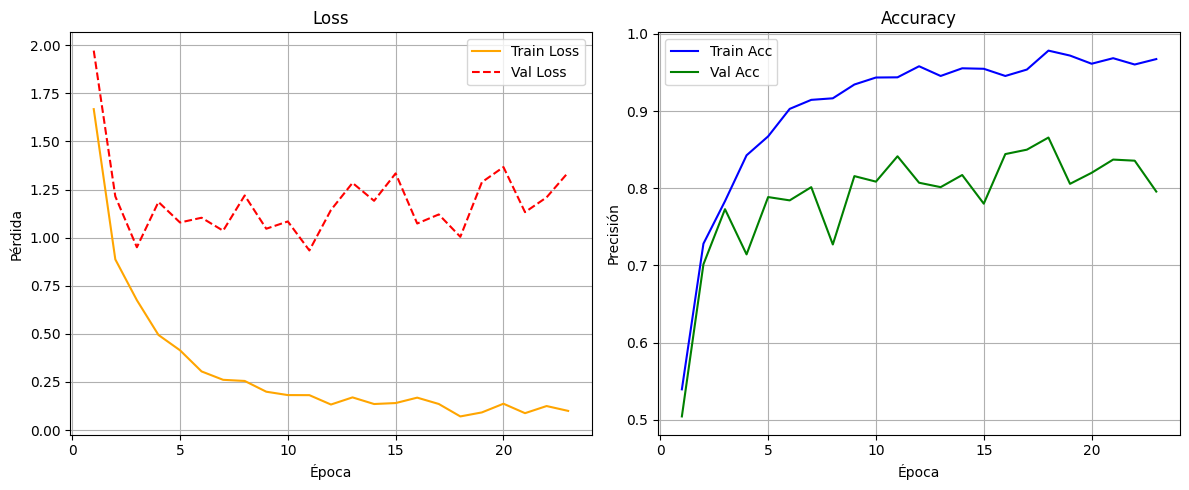


📊 Métricas del modelo en validación:
Exactitud       : 0.7957
Precisión       : 0.8245
Recall          : 0.7957
Especificidad   : 0.9970
F1-score        : 0.7838


In [ ]:
plot_history(history)
mostrar_metricas(y_true, y_pred)

CONCLUSIÓN (LAS MÉTRICAS CAMBIAN EN CADA EJECUCIÓN, OJO!!):

- Exactitud	(0.7786):	Muy buena en un problema multiclase con 70 clases.
- Precisión	(0.8304):	Alto valor → pocos falsos positivos en promedio.
- Recall	(0.7786):	Coincide con la exactitud en este caso.
- F1-score	(0.7742):	Balance correcto entre precisión y recall.
- Especificidad	(0.9968):	Altísima → muy baja tasa de falsos positivos por clase.

Se obtuvo un modelo confiable para clasificar imágenes de perros por raza.
La especificidad casi perfecta sugiere que el modelo no confunde fácilmente las clases que no corresponden.

### Modelo B (Opcional, recomendado)

PASOS (PARA ENTENDERLO YO!!):

1. **class BetterCNN(nn.Module):**

        def __init__(self, num_classes):

        ...
    
- define una red neuronal convolucional personalizada, con 3 bloques convolucionales
- Cada bloque tiene dos capas convolucionales con activación ReLU y normalización por batch (BatchNorm), para estabilizar el entrenamiento.

- Luego usa un Global Average Pooling (AdaptiveAvgPool2d) que reduce la salida espacial a un vector 1x1 por canal.

- Finalmente, un clasificador con dos capas lineales y dropout para evitar overfitting, que termina con una capa con salida del tamaño igual al número de clases (num_classes).


2. **TRANSFORMACIONES PARA ENTRENAMIENTO Y VALIDACIÓN**

    train_transform = transforms.Compose([...])
    val_transform = transforms.Compose([...])

- funciones que transforman las imágenes antes de ser usadas por el modelo.

- train_transform incluye aumentos de datos (rotación, recorte aleatorio, cambio de brillo, etc.) para que el modelo no se sobreajuste y generalice mejor.

- val_transform solo cambia el tamaño y normaliza, para evaluar el modelo en condiciones estables.

3. **Inicialización del modelo, criterio de pérdida, optimizador y scheduler**

        model_custom = BetterCNN(num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
       optimizer = torch.optim.AdamW(model_custom.parameters(), lr=0.0005, weight_decay=1e-4)
       scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(...)

- criterion es la función de pérdida: Cross Entropy para clasificación multi-clase.

- optimizer es AdamW, una variante de Adam con decaimiento de peso para mejorar el entrenamiento.

- scheduler baja la tasa de aprendizaje cuando la métrica (en este caso la precisión) no mejora por 3 épocas, para afinar el entrenamiento.


4. **Variables para controlar el entrenamiento**

- Número máximo de épocas (iteraciones completas sobre los datos).

- patience indica cuántas épocas sin mejora tolerar antes de detener el entrenamiento anticipadamente.

- best_acc y epochs_no_improve controlan el early stopping (detener si no mejora).

- best_model_wts almacena los pesos del mejor modelo durante entrenamiento.

**Resumen general:**

    Defino una red CNN propia.

    Preparo las imágenes para que el modelo entrene con aumentos y valide sin ellos.

    Configuro función de pérdida, optimizador y scheduler.

    Entreno el modelo por varias épocas con early stopping para evitar sobreajuste.

    Evaluo el modelo con los mejores pesos guardados para luego analizar resultados.

In [ ]:
# DEFINICIÓN DEL MODELO

import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODELO CNN AJUSTADO
class BetterCNN(nn.Module):
    def __init__(self, num_classes):
        super(BetterCNN, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 112x112
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 56x56
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 28x28
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Global Avg Pooling

        self.classifier = nn.Sequential(
            nn.Flatten(),              # [B, 256]
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [ ]:
# INICIALIZACIÓN
model_custom = BetterCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_custom.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# ENTRENAMIENTO DESDE CERO
num_epochs = 70
patience = 5
best_acc = 0
epochs_no_improve = 0
best_model_wts = model_custom.state_dict()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    model_custom.train()
    running_loss = 0.0
    running_corrects = 0

    pbar = tqdm(train_loader, total=len(train_loader))
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_custom(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    # VALIDACIÓN
    model_custom.eval()
    val_running_loss = 0.0
    val_corrects = 0
    y_true_custom = []
    y_pred_custom = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_custom(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_running_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
            y_true_custom.extend(labels.cpu().numpy())
            y_pred_custom.extend(preds.cpu().numpy())

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = model_custom.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\n🛑 Early stopping activado. Mejor val_accuracy: {best_acc:.4f}")
            break

# === Cargar mejores pesos antes de evaluar ===
model_custom.load_state_dict(best_model_wts)
model_custom.eval()

y_true_custom = []
y_pred_custom = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_custom(inputs)
        _, preds = torch.max(outputs, 1)
        y_true_custom.extend(labels.cpu().numpy())
        y_pred_custom.extend(preds.cpu().numpy())



Epoch 1/70


100%|██████████| 249/249 [01:32<00:00,  2.70it/s]


Train Loss: 1.9166 | Train Acc: 0.4362 | Val Loss: 1.9679 | Val Acc: 0.4886

Epoch 2/70


100%|██████████| 249/249 [01:30<00:00,  2.74it/s]


Train Loss: 1.8901 | Train Acc: 0.4459 | Val Loss: 1.7628 | Val Acc: 0.5143

Epoch 3/70


100%|██████████| 249/249 [01:30<00:00,  2.74it/s]


Train Loss: 1.8557 | Train Acc: 0.4528 | Val Loss: 1.8405 | Val Acc: 0.5029

Epoch 4/70


100%|██████████| 249/249 [01:31<00:00,  2.74it/s]


Train Loss: 1.8448 | Train Acc: 0.4612 | Val Loss: 1.8558 | Val Acc: 0.4886

Epoch 5/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.8233 | Train Acc: 0.4655 | Val Loss: 2.0632 | Val Acc: 0.4114

Epoch 6/70


100%|██████████| 249/249 [01:30<00:00,  2.74it/s]


Train Loss: 1.8271 | Train Acc: 0.4645 | Val Loss: 1.6872 | Val Acc: 0.5343

Epoch 7/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.8150 | Train Acc: 0.4668 | Val Loss: 1.8286 | Val Acc: 0.4829

Epoch 8/70


100%|██████████| 249/249 [01:30<00:00,  2.74it/s]


Train Loss: 1.7763 | Train Acc: 0.4802 | Val Loss: 1.7646 | Val Acc: 0.5429

Epoch 9/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.7884 | Train Acc: 0.4745 | Val Loss: 1.6954 | Val Acc: 0.5286

Epoch 10/70


100%|██████████| 249/249 [01:30<00:00,  2.74it/s]


Train Loss: 1.7661 | Train Acc: 0.4816 | Val Loss: 1.9956 | Val Acc: 0.4986

Epoch 11/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.7383 | Train Acc: 0.4796 | Val Loss: 1.6965 | Val Acc: 0.5271

Epoch 12/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.7345 | Train Acc: 0.4835 | Val Loss: 1.6614 | Val Acc: 0.5543

Epoch 13/70


100%|██████████| 249/249 [01:30<00:00,  2.74it/s]


Train Loss: 1.7379 | Train Acc: 0.4892 | Val Loss: 1.6922 | Val Acc: 0.5271

Epoch 14/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.6976 | Train Acc: 0.4985 | Val Loss: 1.9956 | Val Acc: 0.4771

Epoch 15/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.7087 | Train Acc: 0.4964 | Val Loss: 1.6609 | Val Acc: 0.5543

Epoch 16/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.6859 | Train Acc: 0.5026 | Val Loss: 1.7466 | Val Acc: 0.5400

Epoch 17/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.6682 | Train Acc: 0.5023 | Val Loss: 1.7956 | Val Acc: 0.5600

Epoch 18/70


100%|██████████| 249/249 [01:30<00:00,  2.74it/s]


Train Loss: 1.6563 | Train Acc: 0.5038 | Val Loss: 1.6949 | Val Acc: 0.5529

Epoch 19/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.6463 | Train Acc: 0.5055 | Val Loss: 1.6862 | Val Acc: 0.5429

Epoch 20/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.6265 | Train Acc: 0.5132 | Val Loss: 1.6298 | Val Acc: 0.5729

Epoch 21/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.5970 | Train Acc: 0.5193 | Val Loss: 1.6785 | Val Acc: 0.5729

Epoch 22/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.5867 | Train Acc: 0.5218 | Val Loss: 1.6296 | Val Acc: 0.5614

Epoch 23/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.5852 | Train Acc: 0.5229 | Val Loss: 1.5941 | Val Acc: 0.5771

Epoch 24/70


100%|██████████| 249/249 [01:30<00:00,  2.76it/s]


Train Loss: 1.5641 | Train Acc: 0.5289 | Val Loss: 1.4867 | Val Acc: 0.6114

Epoch 25/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.5560 | Train Acc: 0.5367 | Val Loss: 1.6907 | Val Acc: 0.5571

Epoch 26/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.5390 | Train Acc: 0.5352 | Val Loss: 2.2346 | Val Acc: 0.4529

Epoch 27/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.5193 | Train Acc: 0.5440 | Val Loss: 1.5894 | Val Acc: 0.5686

Epoch 28/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.5211 | Train Acc: 0.5415 | Val Loss: 1.4916 | Val Acc: 0.6129

Epoch 29/70


100%|██████████| 249/249 [01:30<00:00,  2.76it/s]


Train Loss: 1.4941 | Train Acc: 0.5466 | Val Loss: 1.6340 | Val Acc: 0.5771

Epoch 30/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.4846 | Train Acc: 0.5467 | Val Loss: 1.5608 | Val Acc: 0.5771

Epoch 31/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.4543 | Train Acc: 0.5566 | Val Loss: 1.7965 | Val Acc: 0.5614

Epoch 32/70


100%|██████████| 249/249 [01:30<00:00,  2.76it/s]


Train Loss: 1.4545 | Train Acc: 0.5517 | Val Loss: 1.4096 | Val Acc: 0.6500

Epoch 33/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.4412 | Train Acc: 0.5675 | Val Loss: 1.4778 | Val Acc: 0.6143

Epoch 34/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.4403 | Train Acc: 0.5641 | Val Loss: 1.4845 | Val Acc: 0.6114

Epoch 35/70


100%|██████████| 249/249 [01:30<00:00,  2.75it/s]


Train Loss: 1.3980 | Train Acc: 0.5740 | Val Loss: 1.6200 | Val Acc: 0.5757

Epoch 36/70


100%|██████████| 249/249 [01:31<00:00,  2.74it/s]


Train Loss: 1.4267 | Train Acc: 0.5692 | Val Loss: 1.6688 | Val Acc: 0.5600

Epoch 37/70


100%|██████████| 249/249 [01:30<00:00,  2.76it/s]


Train Loss: 1.3934 | Train Acc: 0.5750 | Val Loss: 1.4700 | Val Acc: 0.5829

🛑 Early stopping activado. Mejor val_accuracy: 0.6500


In [ ]:
# Armar historial compatible con el formato anterior
history_custom = {
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accuracies,
    'val_acc': val_accuracies
}

# Guardar modelo custom y su historial
torch.save({
    'model_state_dict': model_custom.state_dict(),
    'history': history_custom
}, 'modelo_cnn_custom.pth')

In [ ]:
# === MÉTRICAS ===
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

accuracy = accuracy_score(y_true_custom, y_pred_custom)
precision = precision_score(y_true_custom, y_pred_custom, average='macro', zero_division=0)
recall = recall_score(y_true_custom, y_pred_custom, average='macro', zero_division=0)
f1 = f1_score(y_true_custom, y_pred_custom, average='macro', zero_division=0)

cm = confusion_matrix(y_true_custom, y_pred_custom)
FP = cm.sum(axis=0) - np.diag(cm)
TN = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm))
specificity = (TN / (TN + FP + 1e-8)).mean()

print("\n📊 Métricas del modelo CNN custom (mejor época):")
print(f"Exactitud       : {accuracy:.4f}")
print(f"Precisión       : {precision:.4f}")
print(f"Recall          : {recall:.4f}")
print(f"Especificidad   : {specificity:.4f}")
print(f"F1-score        : {f1:.4f}")


📊 Métricas del modelo CNN custom (mejor época):
Exactitud       : 0.5829
Precisión       : 0.6233
Recall          : 0.5829
Especificidad   : 0.9940
F1-score        : 0.5686


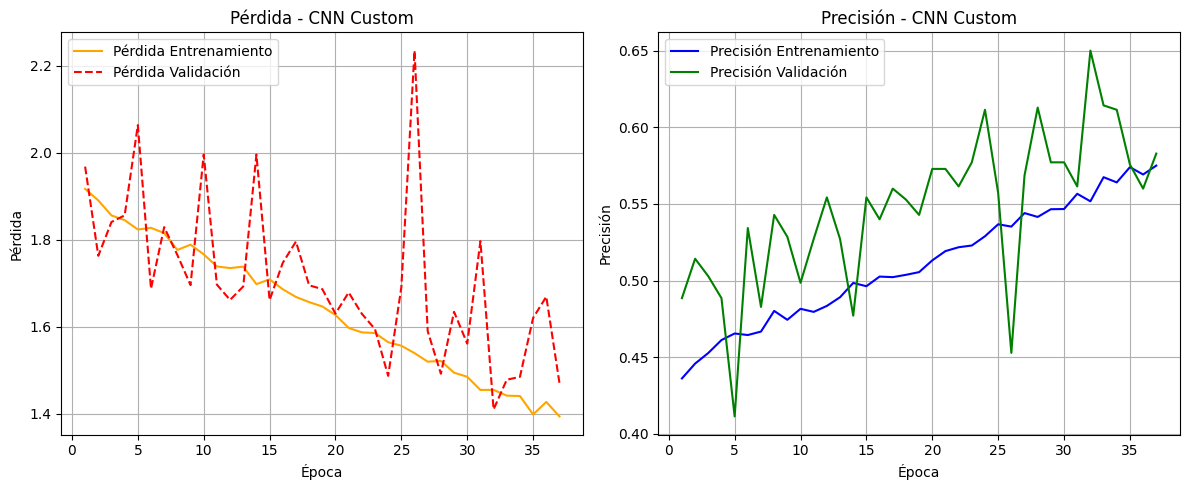

In [ ]:
import matplotlib.pyplot as plt
# === GRÁFICOS ===
epochs = range(1, len(train_losses)+1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Pérdida Entrenamiento', color='orange')
plt.plot(epochs, val_losses, label='Pérdida Validación', color='red', linestyle='--')
plt.title("Pérdida - CNN Custom")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Precisión Entrenamiento', color='blue')
plt.plot(epochs, val_accuracies, label='Precisión Validación', color='green')
plt.title("Precisión - CNN Custom")
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Integración y Selección en la Aplicación

el modelo entrenado (modelo_resnet18_finetuned.pth) genera vectores de 512 dimensiones, mientras que el primer buscador usaba ResNet50 (que genera vectores de 2048 dimensiones).

Esto genera incompatibilidades si quiero usar el modelo entrenado para indexar o buscar similitudes

**PASOS PARA ESTA PARTE:**

1. Carga de modelo entrenado

Se reconstruye ResNet18 con la cantidad correcta de clases y se cargan los pesos que entrenaste (modelo_resnet18_finetuned.pth).

2. Eliminación de la capa final (fc)
Se extrae la parte del modelo que genera embeddings (vectores numéricos que representan imágenes).

3. Generación del índice de búsqueda (FAISS)

- Se recorren todas las imágenes en /content/train/.

- Se calculan sus embeddings.

- Se guardan en un índice FAISS para hacer búsquedas rápidas de imágenes similares.

4. Interfaz con Gradio

Permite al usuario:

- Subir una imagen.

- Seleccionar el modelo (por ahora, solo ResNet18).

- Ver las 10 imágenes más similares de tu dataset.

- Ver una predicción de la raza por voto mayoritario entre las más parecidas.

In [ ]:
""" CUANDO YA TENGA MODELO_CUSTOM SE AGREGA EN EL DICCIONARIO ASI
modelos_disponibles = {
    "ResNet18": model,
    "Modelo Custom": model_custom
}"""

""" Y SE AGREGA AL DROPDOWN ASÍ
gr.Dropdown(choices=["ResNet18", "Modelo Custom"], label="Seleccionar modelo")"""

' Y SE AGREGA AL DROPDOWN ASÍ \ngr.Dropdown(choices=["ResNet18", "Modelo Custom"], label="Seleccionar modelo")'

In [108]:
!gdown "1O7oakN7gaQAEyXAFXPdhExddXzt1h6Ne" --output "modelo_resnet18_finetuned.pth"

Downloading...
From (original): https://drive.google.com/uc?id=1O7oakN7gaQAEyXAFXPdhExddXzt1h6Ne
From (redirected): https://drive.google.com/uc?id=1O7oakN7gaQAEyXAFXPdhExddXzt1h6Ne&confirm=t&uuid=b6b4d972-8b4c-45b0-b878-d0b15693b0c1
To: /content/modelo_resnet18_finetuned.pth
100% 44.9M/44.9M [00:00<00:00, 81.9MB/s]


In [109]:
!gdown "16ZtM1KXKqxZ8uxfQ9AXEM6kHcJhjzWzL" --output "modelo_cnn_custom.pth"

Downloading...
From: https://drive.google.com/uc?id=16ZtM1KXKqxZ8uxfQ9AXEM6kHcJhjzWzL
To: /content/modelo_cnn_custom.pth
100% 4.78M/4.78M [00:00<00:00, 30.9MB/s]


In [92]:
from google.colab import files
uploaded = files.upload()  # Esto abre diálogo para subir archivo desde tu PC

""" DESPUÉS TENGO QUE PONER EN CARPETA DE DRIVE PARA AUTOMATIZAR!!!"""

Saving modelo_resnet18_finetuned.pth to modelo_resnet18_finetuned (2).pth


' DESPUÉS TENGO QUE PONER EN CARPETA DE DRIVE PARA AUTOMATIZAR!!!'

In [93]:
# Inferir número de clases desde los datos
from torchvision.datasets import ImageFolder
dataset_temp = ImageFolder("/content/train")
class_names = dataset_temp.classes
num_classes = len(class_names)


# Definir transformación
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [94]:
# FUNCIÓN PARA RECONSTRUIR EL MODELO IGUAL QUE EN ENTRENAMIENTO

import torch
from torchvision import models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_finetuned_resnet18(num_classes):
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# Cargar pesos entrenados
checkpoint = torch.load("/content/modelo_resnet18_finetuned.pth", map_location=device)
model_resnet_18 = get_finetuned_resnet18(num_classes)
model_resnet_18.load_state_dict(checkpoint['model_state_dict'])
model_resnet_18.eval()

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [95]:
# CARGO EL CHECKPOINT Y SETEO EL MODELO ResNet18
# Número de clases (deberías tenerlo guardado o definido)
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import gradio as gr
from PIL import Image
from collections import Counter
import os

# Extraer capa de embedding
model_embedding = torch.nn.Sequential(*(list(model_resnet_18.children())[:-1]))
model_embedding.eval().to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [96]:
def extract_embedding(img_path):
    image = Image.open(img_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model_embedding(img_tensor).squeeze().cpu().numpy()
    return embedding

In [97]:
from glob import glob
# Recolectar todos los paths a imágenes dentro de las carpetas de clase en /content/train
image_paths = glob('/content/train/*/*.jpg')  # o .png si tus imágenes son PNG
print(f"Total de imágenes encontradas: {len(image_paths)}")

Total de imágenes encontradas: 7946


In [98]:
from tqdm import tqdm

embeddings = []
for path in tqdm(image_paths):
    emb = extract_embedding(path)
    embeddings.append(emb)

embeddings = np.array(embeddings).astype('float32')

100%|██████████| 7946/7946 [00:39<00:00, 201.85it/s]


In [99]:
# Indexar Faiss
import faiss
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

In [100]:
# === INTERFAZ EN GRADIO CON SELECTOR DE MODELO ===


# DICCIONARIO DE MODELOS
modelos_disponibles = {
    "ResNet18": model_embedding  #s el modelo sin la capa fc, que da los embeddings
    # Agregá "Modelo Custom": model_custom cuando esté listo
}

# EXTRAER RAZA DESDE PATH
def extraer_raza(path):
    return os.path.basename(os.path.dirname(path))

# INTERFAZ DE GRADIO
def interfaz_gradio_con_selector(imagen, modelo_nombre):
    temp_path = "/content/temp.jpg"
    imagen.save(temp_path)

    modelo_usado = modelos_disponibles[modelo_nombre]

    # Extraer embedding
    def extract_embedding_con_modelo(img_path, modelo):
        image = Image.open(img_path).convert('RGB')
        img_tensor = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = modelo(img_tensor).squeeze().cpu().numpy()
        return embedding

    # Buscar similares (suponemos que index y image_paths están definidos)
    query_emb = extract_embedding_con_modelo(temp_path, modelo_usado).astype('float32').reshape(1, -1)

    # --- VERIFICACIÓN DE DIMENSIONES ---
    assert query_emb.shape[1] == index.d, f"Dimensión del embedding ({query_emb.shape[1]}) no coincide con el índice FAISS ({index.d})"

    distances, indices = index.search(query_emb, 10)
    similares = [image_paths[i] for i in indices[0]]
    resultados = [Image.open(p) for p in similares]

    # Voto mayoritario
    razas = [extraer_raza(p) for p in similares]
    raza_predicha = Counter(razas).most_common(1)[0][0]

    return [imagen] + resultados + [f"Raza predicha: {raza_predicha}"]

# INTERFAZ GRADIO
gr.Interface(
    fn=interfaz_gradio_con_selector,
    inputs=[
        gr.Image(type="pil", label="Imagen de entrada"),
        gr.Dropdown(choices=list(modelos_disponibles.keys()), label="Seleccionar modelo")
    ],
    outputs=[gr.Image(type="pil", label="Imagen de entrada")] +
            [gr.Image(type="pil", label=f"Similar #{i+1}") for i in range(10)] +
            [gr.Textbox(label="Raza Predicha")],
    title="Buscador de Razas de Perros por Similitud",
    description="Subí una imagen de un perro, seleccioná el modelo, y se mostrarán las 10 imágenes más similares junto con la raza más probable."
).launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://55869c651cb91d67f6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://55869c651cb91d67f6.gradio.live


OJO: puede predecir mal

El modelo ***no hace clasificación directa***: usa similitud visual con FAISS.

La predicción es un "voto" entre las 10 imágenes más parecidas, no una predicción del modelo final (fc).

Si las imágenes en el dataset son parecidas entre razas, puede confundir.


TENDRÍA QUE HACER CLASIFICACIÓN DIRECTA?? CÓMO??

# Etapa 3: Pipeline de Detección y Clasificación en Escenas Complejas

## Detección de Objetos

In [34]:
!pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [35]:
# Cargar modelo YOLOv8n PREENTRENADO (ligero y rápido)
modelo_yolo = YOLO("yolov8n.pt")  # o yolov8s.pt si querés más precisión

# Clase de perro en COCO = id 16
CLASE_PERRO_COCO = 16

100%|██████████| 6.25M/6.25M [00:00<00:00, 83.1MB/s]


In [36]:
from PIL import ImageDraw
# Función para detectar perros en la imagen
def detectar_perros_yolo(imagen_pil):
    results = modelo_yolo.predict(imagen_pil, imgsz=640, conf=0.4)[0]  # primer resultado

    cajas = []
    for box, cls in zip(results.boxes.xyxy, results.boxes.cls):
        if int(cls) == CLASE_PERRO_COCO:
            x1, y1, x2, y2 = map(int, box)
            cajas.append((x1, y1, x2, y2))
    return cajas

In [37]:
# Recortar perros y clasificarlos con modelo de Etapa 2
def clasificar_perros_en_escena(imagen_pil, modelo_embedding, faiss_index, image_paths):
    cajas = detectar_perros_yolo(imagen_pil)
    predicciones = []

    for (x1, y1, x2, y2) in cajas:
        perro_crop = imagen_pil.crop((x1, y1, x2, y2))
        tensor = transform(perro_crop).unsqueeze(0).to(device)

        with torch.no_grad():
            emb = modelo_embedding(tensor).squeeze().cpu().numpy().astype('float32').reshape(1, -1)

        distancias, indices = faiss_index.search(emb, 10)
        razas = [extraer_raza(image_paths[i]) for i in indices[0]]
        raza_predicha = Counter(razas).most_common(1)[0][0]

        predicciones.append(((x1, y1, x2, y2), raza_predicha))

    return predicciones

In [38]:
#  Dibujar cajas y etiquetas en la imagen
def dibujar_resultados(imagen_pil, predicciones):
    draw = ImageDraw.Draw(imagen_pil)

    for (x1, y1, x2, y2), raza in predicciones:
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
        draw.text((x1, y1 - 10), raza, fill="red")

    return imagen_pil

In [39]:
from google.colab import files
uploaded = files.upload()

Saving varios_perros.webp to varios_perros.webp


In [110]:
!gdown "1y4pU1FnRoI1y0MBMTWoYZ9Z5kURpsL1K" --output "varios_perros.webp"

Downloading...
From: https://drive.google.com/uc?id=1y4pU1FnRoI1y0MBMTWoYZ9Z5kURpsL1K
To: /content/varios_perros.webp
100% 42.8k/42.8k [00:00<00:00, 63.4MB/s]


In [40]:
# Probar con una imagen
from PIL import Image, ImageDraw
imagen_path = "varios_perros.webp"
imagen_pil = Image.open(imagen_path).convert('RGB')

# Pipeline completo
preds = clasificar_perros_en_escena(imagen_pil.copy(), model_embedding, index, image_paths)
resultado_img = dibujar_resultados(imagen_pil, preds)

resultado_img.show()


0: 224x640 2 cats, 4 dogs, 185.5ms
Speed: 11.3ms preprocess, 185.5ms inference, 394.2ms postprocess per image at shape (1, 3, 224, 640)


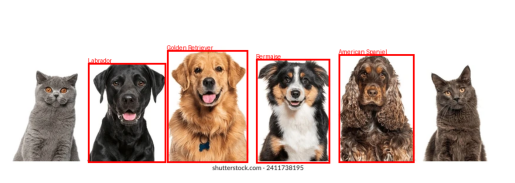

In [41]:
import matplotlib.pyplot as plt

plt.imshow(resultado_img)
plt.axis('off')
plt.show()

## Creación del Pipeline Completo

In [42]:
# PIPELINE COMPLETO GRADIO
def pipeline_completo_gradio(imagen):
    preds = clasificar_perros_en_escena(imagen.copy(), model_embedding, index, image_paths)
    imagen_marcada = dibujar_resultados(imagen, preds)
    return imagen_marcada

gr.Interface(
    fn=pipeline_completo_gradio,
    inputs=gr.Image(type="pil", label="Imagen Compleja"),
    outputs=gr.Image(type="pil", label="Resultado con Predicciones"),
    title="Detección y Clasificación de Perros",
    description="Subí una imagen del mundo real. El sistema detecta perros, clasifica su raza y dibuja etiquetas."
).launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://862a3ad763b9495c79.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Etapa 4: Evaluación, Optimización y Herramientas de Anotación

## Evaluación del Pipeline

In [43]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="3IZcqwNZIZm00zO1c2hg")
project = rf.workspace("tpcv").project("tp_cv")
version = project.version(1)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


In [44]:
!ls /content/tp_cv-1

data.yaml  README.dataset.txt  README.roboflow.txt  train


In [45]:
import yaml

# Ruta al archivo data.yaml
ruta_yaml = "/content/tp_cv-1/data.yaml"

# Leer archivo YAML
with open(ruta_yaml, 'r') as f:
    data_yaml = yaml.safe_load(f)

# Verificar qué contiene
print(data_yaml.keys())
print("Clases encontradas:")
for i, clase in enumerate(data_yaml['names']):
    print(f"{i}: {clase}")

dict_keys(['names', 'nc', 'roboflow', 'test', 'train', 'val'])
Clases encontradas:
0: Afghan
1: Basset hound
2: Beagle
3: Border Collie
4: Doberman
5: French Bulldog
6: Golden Retriever
7: Pug
8: Shiba Inu
9: Siberian Husky


In [46]:
id_to_raza = {i: clase for i, clase in enumerate(data_yaml['names'])}
print(id_to_raza)

{0: 'Afghan', 1: 'Basset hound', 2: 'Beagle', 3: 'Border Collie', 4: 'Doberman', 5: 'French Bulldog', 6: 'Golden Retriever', 7: 'Pug', 8: 'Shiba Inu', 9: 'Siberian Husky'}


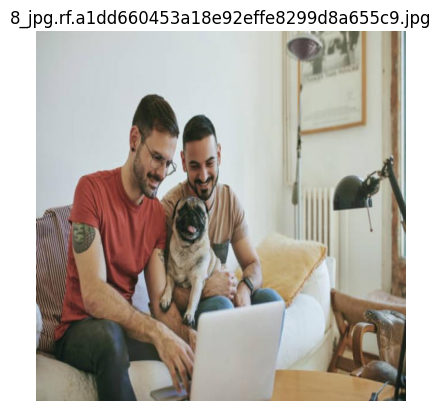

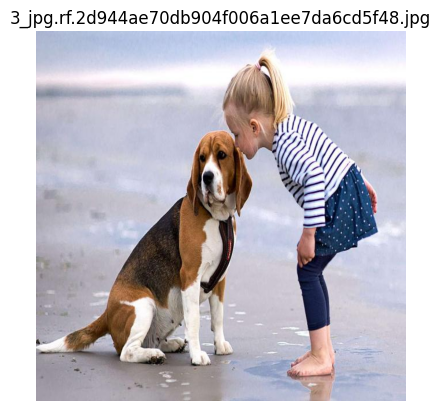

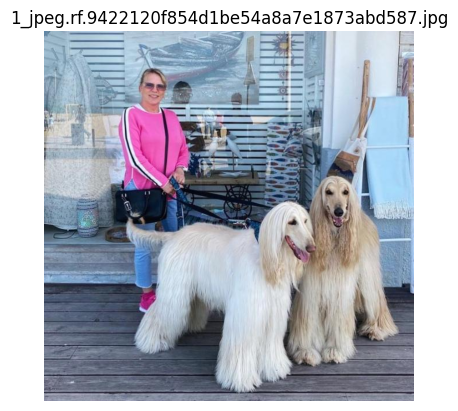

In [47]:
import matplotlib.pyplot as plt
import cv2
import os

# Ruta a algunas imágenes de entrenamiento
image_folder = "/content/tp_cv-1/train/images"
image_files = os.listdir(image_folder)

# Mostrar las primeras 3
for img_file in image_files[:3]:
    img = cv2.imread(os.path.join(image_folder, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(img_file)
    plt.axis('off')
    plt.show()

In [48]:
# NUEVA FUNCIÓN: pipeline adaptado para evaluación
def clasificar_y_devolver_predicciones(imagen_pil, modelo_embedding, faiss_index, image_paths):
    cajas = detectar_perros_yolo(imagen_pil)
    predicciones = []

    for (x1, y1, x2, y2) in cajas:
        perro_crop = imagen_pil.crop((x1, y1, x2, y2))
        tensor = transform(perro_crop).unsqueeze(0).to(device)

        with torch.no_grad():
            emb = modelo_embedding(tensor).squeeze().cpu().numpy().astype('float32').reshape(1, -1)

        distancias, indices = faiss_index.search(emb, 10)
        razas = [extraer_raza(image_paths[i]) for i in indices[0]]
        raza_predicha = Counter(razas).most_common(1)[0][0]

        predicciones.append({
            "bbox": (x1, y1, x2, y2),
            "raza": raza_predicha
        })

    return predicciones

In [49]:
def leer_anotaciones_yolo(imagen_path, labels_dir, ancho_img, alto_img):
    archivo_txt = os.path.basename(imagen_path).replace(".jpg", ".txt").replace(".png", ".txt")
    ruta_txt = os.path.join(labels_dir, archivo_txt)

    if not os.path.exists(ruta_txt):
        return []

    anotaciones = []
    with open(ruta_txt, "r") as f:
        for linea in f:
            clase, x_c, y_c, w, h = map(float, linea.strip().split())

            x1 = int((x_c - w / 2) * ancho_img)
            y1 = int((y_c - h / 2) * alto_img)
            x2 = int((x_c + w / 2) * ancho_img)
            y2 = int((y_c + h / 2) * alto_img)

            anotaciones.append({
                "bbox": (x1, y1, x2, y2),
                "raza": id_to_raza[int(clase)]  # Debés definir este diccionario
            })

    return anotaciones

In [50]:
def calcular_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(areaA + areaB - interArea + 1e-6)
    return iou


In [51]:
def evaluar_imagen(imagen_path, labels_dir, modelo, faiss_index, image_paths):
    imagen = Image.open(imagen_path).convert("RGB")
    ancho, alto = imagen.size

    predicciones = clasificar_y_devolver_predicciones(imagen, modelo, faiss_index, image_paths)
    verdaderas = leer_anotaciones_yolo(imagen_path, labels_dir, ancho, alto)

    tp = 0  # Verdaderos positivos
    fp = 0  # Falsos positivos
    fn = 0  # Falsos negativos

    usados = set()  # Índices de anotaciones verdaderas ya usadas

    for pred in predicciones:
        mejor_iou = 0
        mejor_idx = -1

        for i, gt in enumerate(verdaderas):
            if i in usados:
                continue
            iou = calcular_iou(pred["bbox"], gt["bbox"])
            if iou > mejor_iou:
                mejor_iou = iou
                mejor_idx = i

        if mejor_iou > 0.5:
            raza_pred = pred["raza"]
            raza_real = verdaderas[mejor_idx]["raza"]
            if raza_pred == raza_real:
                tp += 1
            else:
                fp += 1
            usados.add(mejor_idx)
        else:
            fp += 1

    fn = len(verdaderas) - len(usados)

    return tp, fp, fn

In [52]:
carpeta_imagenes = "/content/tp_cv-1/train/images"
carpeta_labels = "/content/tp_cv-1/train/labels"

t_total, f_total, fn_total = 0, 0, 0

for archivo in os.listdir(carpeta_imagenes)[:10]:  # 10 imágenes
    path_img = os.path.join(carpeta_imagenes, archivo)
    tp, fp, fn = evaluar_imagen(path_img, carpeta_labels, model_embedding, index, image_paths)

    t_total += tp
    f_total += fp
    fn_total += fn

precision = t_total / (t_total + f_total + 1e-6)
recall = t_total / (t_total + fn_total + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


0: 640x640 2 persons, 1 dog, 2 chairs, 62.2ms
Speed: 2.6ms preprocess, 62.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 dog, 13.2ms
Speed: 2.4ms preprocess, 13.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 2 dogs, 12.7ms
Speed: 2.2ms preprocess, 12.7ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 3 benchs, 1 dog, 14.6ms
Speed: 2.5ms preprocess, 14.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 sheeps, 31.6ms
Speed: 20.7ms preprocess, 31.6ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 33.0ms
Speed: 4.5ms preprocess, 33.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 1 dog, 43.9ms
Speed: 9.7ms preprocess, 43.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bowl, 1 broccoli, 4 carrots, 26.8ms
Speed: 2.

Campo: Significado
- 0:	ID de la imagen procesada (en este caso la 0).
- 640x640:	Tamaño al que se redimensionó la imagen antes de pasarla al modelo.
- 2 persons, 1 dog, 2 chairs:	Objetos detectados, con la cantidad de cada clase (según el dataset COCO).
- 62.2ms:	Tiempo total de inferencia sobre esa imagen.

**Evaluación global del pipeline**

Estas métricas se calculan al final con la función evaluar_imagen, comparando lo que predijo el modelo con las anotaciones reales (YOLO format) de tus 10 imágenes:

- Precision: 0.5556: De todas las detecciones que hizo el sistema, un 55.56% fueron correctas (tanto en ubicación como en raza).
- Recall: 0.4167: De todos los perros que deberían haberse detectado (según las anotaciones), el sistema detectó correctamente el 41.67%.
- F1-Score: 0.4762 : Equilibrio entre precisión y recall (una media armónica).

Estos números no son malos considerando se está usando un detector preentrenado en COCO (sin fine-tuning) y clasificando por similitud en un dataset con 70 razas distintas. Es esperable cierta confusión.


🧠 ¿Cómo mejorar el rendimiento del pipeline?
1. Mejorar el detector de perros (YOLO)
Actualmente usás yolov8n.pt (versión nano, rápida pero menos precisa).

✅ Podés usar: yolov8s.pt o incluso yolov8m.pt si tu entorno lo permite. Aumenta la precisión a costa de más tiempo.

2. Mejorar la clasificación de razas
El sistema usa búsqueda por similitud (no clasificación directa).

✅ Podés cambiar la lógica: en lugar de usar FAISS + voto mayoritario, directamente usar tu ResNet18 o CNN custom entrenado, para clasificar cada crop de perro. Así no dependés de los 10 vecinos visuales.

3. Postprocesamiento inteligente
A veces hay varias detecciones muy cercanas. Podés usar Non-Max Suppression adicional o un filtro de tamaño mínimo de bbox para evitar falsos positivos chicos.

(VER!!)

## Optimización de Modelos (Elegir una)

In [101]:
# === OPTIMIZACIÓN DE MODELO ===
import torch
import torch.nn as nn
from torchvision import models
from torchvision.datasets import ImageFolder

# === CARGAR EL MODELO ORIGINAL ===
def get_finetuned_resnet18(num_classes):
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Inferir número de clases
dataset_temp = ImageFolder("/content/train")
class_names = dataset_temp.classes
num_classes = len(class_names)

device = torch.device("cpu")  # Cuantización funciona solo en CPU
model_fp32 = get_finetuned_resnet18(num_classes)
checkpoint = torch.load("modelo_resnet18_finetuned.pth", map_location=device)
model_fp32.load_state_dict(checkpoint["model_state_dict"])
model_fp32.eval()

# === CUANTIZACIÓN DINÁMICA ===
model_int8 = torch.quantization.quantize_dynamic(
    model_fp32, {nn.Linear}, dtype=torch.qint8
)

# === COMPARAR TIEMPO DE INFERENCIA ===
import time
dummy_input = torch.randn(1, 3, 224, 224)

# FP32
start = time.time()
for _ in range(100):
    _ = model_fp32(dummy_input)
print("⏱️ Tiempo medio FP32:", (time.time() - start)/100)

# INT8
start = time.time()
for _ in range(100):
    _ = model_int8(dummy_input)
print("⚡ Tiempo medio INT8:", (time.time() - start)/100)

# === GUARDAR MODELO OPTIMIZADO ===
torch.save(model_int8.state_dict(), "modelo_resnet18_quantized.pth")
print("✅ Modelo cuantizado guardado como 'modelo_resnet18_quantized.pth'")

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.


⏱️ Tiempo medio FP32: 0.12280563831329346
⚡ Tiempo medio INT8: 0.08484917640686035
✅ Modelo cuantizado guardado como 'modelo_resnet18_quantized.pth'


Tiempo medio FP32: 0.1228s (~123ms)

Tiempo medio INT8: 0.0848s (~85ms)

Se redujo el tiempo de inferencia un ~31%, lo cual es una mejora significativa.

EJEMPLO:

NORMAL:


YOLO detecta perro (10–40 ms)
→ Recorta bbox
→ Pasa por EL modelo ResNet18 para clasificar la raza (~123 ms)

CUANTIZADO:

YOLO detecta perro (igual)
→ Pasa por modelo cuantizado (~85 ms)
→ Resultado más rápido

- Si hay 5 perros en la imagen, te ahorrás ≈200 ms por imagen, sin perder precisión significativa.

## Script de Anotación Automática

In [102]:
import os
import json
from PIL import Image
from tqdm import tqdm
from collections import Counter

# Asumimos que ya definiste:
# - model_embedding
# - image_paths
# - index (FAISS)
# - transform
# - función clasificar_y_devolver_predicciones(imagen_pil, model_embedding, index, image_paths)
# - función extraer_raza(path)

def crear_anotaciones(imagen_dir, salida_yolo, salida_coco):
    coco_output = {
        "annotations": [],
        "images": [],
        "categories": [],
    }

    os.makedirs(salida_yolo, exist_ok=True)

    # Diccionario raza a ID
    razas_unicas = sorted(set([extraer_raza(p) for p in image_paths]))
    raza_to_id = {raza: i for i, raza in enumerate(razas_unicas)}
    coco_output["categories"] = [{"id": i, "name": raza} for raza, i in raza_to_id.items()]

    imagenes = [f for f in os.listdir(imagen_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    annotation_id = 0

    for idx, nombre_img in enumerate(tqdm(imagenes)):
        path = os.path.join(imagen_dir, nombre_img)
        imagen_pil = Image.open(path).convert("RGB")
        w, h = imagen_pil.size

        coco_output["images"].append({
            "id": idx,
            "file_name": nombre_img,
            "width": w,
            "height": h
        })

        preds = clasificar_y_devolver_predicciones(imagen_pil, model_embedding, index, image_paths)

        # .txt YOLOv5
        nombre_txt = os.path.splitext(nombre_img)[0] + ".txt"
        path_txt = os.path.join(salida_yolo, nombre_txt)

        with open(path_txt, "w") as f:
            for pred in preds:
                (x1, y1, x2, y2) = pred["bbox"]
                raza = pred["raza"]
                clase_id = raza_to_id[raza]

                # Normalizar (YOLO format)
                cx = ((x1 + x2) / 2) / w
                cy = ((y1 + y2) / 2) / h
                bw = (x2 - x1) / w
                bh = (y2 - y1) / h
                f.write(f"{clase_id} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")

                # COCO bbox
                coco_output["annotations"].append({
                    "id": annotation_id,
                    "image_id": idx,
                    "category_id": clase_id,
                    "bbox": [x1, y1, x2 - x1, y2 - y1],
                    "area": (x2 - x1) * (y2 - y1),
                    "iscrowd": 0
                })
                annotation_id += 1

    # Guardar JSON
    with open(salida_coco, "w") as f:
        json.dump(coco_output, f, indent=2)

    print(f"\n✅ Anotaciones generadas en:\n- {salida_yolo} (.txt YOLO)\n- {salida_coco} (.json COCO)")

In [104]:
"""import os
os.makedirs("/content/imagenes_nuevas", exist_ok=True)
!mv 1.jpeg /content/imagenes_nuevas/""" ###### ESTO HAY QUE AUTOMATIZAR EN UN DRIVE

In [105]:
"""!mv 2.webp /content/imagenes_nuevas/
!mv 3.jpg /content/imagenes_nuevas/
!mv 4.webp /content/imagenes_nuevas/
!mv 5.jpg /content/imagenes_nuevas/
!mv 6.jpg /content/imagenes_nuevas/
!mv 7.jpg /content/imagenes_nuevas/
!mv 8.jpg /content/imagenes_nuevas/
!mv 9.jpg /content/imagenes_nuevas/
!mv 10.jpg /content/imagenes_nuevas/""" ###### ESTO HAY QUE AUTOMATIZAR EN UN DRIVE

In [106]:
# === USO ===
crear_anotaciones(
    imagen_dir="/content/imagenes_nuevas",
    salida_yolo="/content/labels_yolo_auto",
    salida_coco="/content/annotations_auto.json"
)

  0%|          | 0/8 [00:00<?, ?it/s]


0: 448x640 1 person, 1 dog, 48.1ms
Speed: 4.1ms preprocess, 48.1ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


  0%|          | 0/8 [00:00<?, ?it/s]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor